In [54]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

import acoutreams

k0 =  2 * np.pi * 50000 / 343
materials = [acoutreams.AcousticMaterial(1050 + 100j, 2350 - 300j), 
            acoutreams.AcousticMaterial(998, 1497)]
lmax = 3
radii = [0.0075, 0.0075]
positions = [[-0.004, 0, -0.0075], [0.004, 0, 0.0075]]
lattice = 0.035
kz = 0

In [55]:
spheres = [acoutreams.AcousticTMatrix.sphere(lmax, k0, r, materials) for r in radii]
tm = acoutreams.AcousticTMatrix.cluster(spheres, positions).latticeinteraction.solve(lattice, kz)

In [56]:
inc = acoutreams.plane_wave_scalar([tm.k0, 0, 0], k0=tm.k0, material=tm.material)
sca = tm.sca(inc)

In [59]:
x = np.linspace(-0.5*lattice, 0.5*lattice, 101)
z = np.linspace(-0.5*lattice, 0.5*lattice, 101)
def compute_intensity(i, j, tm, radii, inc, sca):
    r = [x[j], 0, z[i]]  
    if tm.valid_points(r, radii):
        swb = acoutreams.ScalarSphericalWaveBasis.default(0, positions=[r])
        field = sca.expandlattice(basis=swb).pfield(r) 
        result = 0.5 * np.abs(inc.pfield(r) + field)**2  
    else:
        result = np.nan
    return i, j, result  
results = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j, tm, radii, inc, sca) 
    for i in range(len(z)) 
    for j in range(len(x))
)
intensity = np.zeros((len(z), len(x)))
for i, j, result in results:
    intensity[i, j] = result

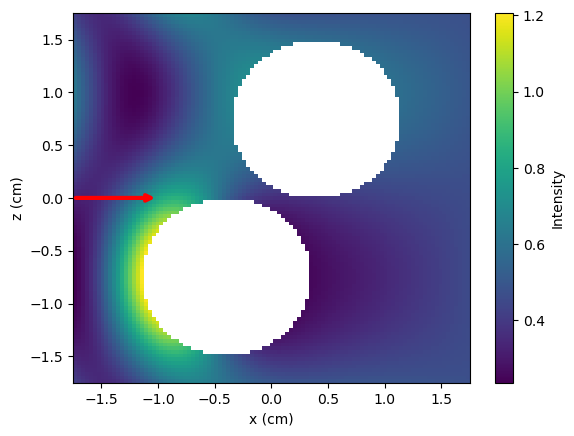

In [62]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity,
    extent = [x.min() * 100, x.max() * 100, z.min() * 100, z.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("Intensity")
ax.set_xlabel("x (cm)")
ax.set_ylabel("z (cm)")
ax.annotate(
    "", 
    xy=(-1.0, 0),
    xytext=(-1.75, 0), 
    arrowprops=dict(
        arrowstyle="->",
        lw=3, 
        color="red" 
    )
)
plt.show()